# Introduction
## Basic Tutorial III: Functional Workflow

**[AutoRA](https://pypi.org/project/autora/)** (**Au**tomated **R**esearch **A**ssistant) is an open-source framework designed to automate various stages of empirical research, including model discovery, experimental design, and data collection.

This notebook is the third of four notebooks within the basic tutorials of ``autora``. We suggest that you go through these notebooks in order as each builds upon the last. However, each notebook is self-contained and so there is no need to *run* the content of the last notebook for your current notebook. We will here provide a link to each notebook, but we will also provide a link at the end of each notebook to navigate you to the next notebook.

[AutoRA Basic Tutorial I: Components](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-I-Components/) <br>
[AutoRA Basic Tutorial II: Loop Constructs](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-II-Loop-Constructs/) <br>
[AutoRA Basic Tutorial III: Functional Workflow](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-III-Functional-Workflow/) <br>
[AutoRA Basic Tutorial IV: Customization](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-IV-Customization/) <br>

These notebooks provide a comprehensive introduction to the capabilities of ``autora``. **It demonstrates the fundamental components of ``autora``, and how they can be combined to facilitate automated (closed-loop) empirical research through synthetic experiments.**

**How to use this notebook** *You can progress through the notebook section by section or directly navigate to specific sections. If you choose the latter, it is recommended to execute all cells in the notebook initially, allowing you to easily rerun the cells in each section later without issues.*

## Tutorial Setup

We will here import some standard python packages, set seeds for replicability, and define a plotting function.

In [ ]:
#### Installation ####
!pip install -q "autora[theorist-bms]"

#### Import modules ####
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

#### Set seeds ####
np.random.seed(42)
torch.manual_seed(42)

#### Define plot function ####
def plot_from_state(state):    
    model_label = f"Model: {state.model.repr()}" if state.model.repr() else "Model"
    experiment_data = state.experiment_data.sort_values(by=["x"])
    ground_x = np.linspace(state.variables.independent_variables[0].value_range[0],state.variables.independent_variables[0].value_range[1],100)

    f = plt.figure(figsize=(4,3))
    plt.plot(experiment_data["x"], experiment_data["y"], 'o', label = None)
    plt.plot(ground_x, state.model.predict(ground_x.reshape(-1, 1)), alpha=.8, label=model_label)
    plt.plot(ground_x, np.sin(ground_x), alpha=.8,  label='Ground Truth: sin(x)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## States

Using the functions and objects in `autora.state`, we can build flexible pipelines and cycles which operate on state
objects. State objects are containers with specialized functionality that will hold ou variables, data, and models. This state can be acted upon by experimentalists, experiment runners, and theorists. 

In tutorial I, we had experimentalists define new conditions, experiment runners collect new observations, and theorists model the data. To do this, we used the output of one as the input of the other, such as: 

`conditions = experimentalist(...)` $\rightarrow$ <br>
`observations = experiment_runner(conditions,...)` $\rightarrow$ <br>
`model = theorist(conditions, observations)` <br>

This chaining is embedded within the `State` functionality. To act on a state, we must wrap each of our experimentalist(s), experiment_runner(s), and theorist(s) so that they:
- operate on the `State`, and
- return a modified object of the **same type** `State`.

### Defining The State

We use the `StandardState` object bundled with `autora`: `StandardState`. Let's begin by populating the state with *variable information* (`variables`), *seed condition data* (`conditions`), and a *dataframe* (`pd.DataFrame(columns=["x","y"])`) that will hold our conditions (`x`) and observations (`y`).

In [ ]:
from autora.variable import Variable, ValueType, VariableCollection
from autora.experimentalist.random_ import random_pool
from autora.state.bundled import StandardState

#### Define variable data ####
iv = Variable(name="x", value_range=(0, 2 * np.pi), allowed_values=np.linspace(0, 2 * np.pi, 30))
dv = Variable(name="y", type=ValueType.REAL)
variables = VariableCollection(independent_variables=[iv],dependent_variables=[dv])

#### Define seed condition data ####
conditions = random_pool(variables, num_samples=10)

#### Initialize State ####
s = StandardState(
    variables = variables,
    conditions=conditions,
    experiment_data = pd.DataFrame(columns=["x","y"])
)

## Viewing the State

Now, let's view the contents of the state we just initialized.

In [ ]:
print(s)

StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  4.333231
1  5.633201
2  3.899908
3  5.849862
4  3.249923
5  0.216662
6  4.549893
7  2.383277
8  4.549893
9  4.116570, experiment_data=Empty DataFrame
Col

We can view all of the content we provided the state more directly if we choose.

In [ ]:
print("\033[1mThe variables we provided:\033[0m")
print(s.variables)

print("\n\033[1mThe conditions we provided:\033[0m")
print(s.conditions)

print("\n\033[1mThe dataframe we provided:\033[0m")
print(s.experiment_data)

The variables we provided:
VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[])

The conditions we provided:
          x
0  4.333231
1  5.633201
2  3.899908
3  5.849862
4  3.249923
5  0.216662
6  4.549893
7  2.383277
8  4.549893
9  4.116570

The dataframe w

## AutoRA Components and the State

Now that we have initialized the state, we need to start preparing components of `AutoRA` to work with the state - namely, experiment runners, experimentalists, and theorists. 

These components are defined in the same way as past tutorials. All we need to do so that these can function within the state is to wrap them in specialized state functions. The wrappers are:
- `on_state()` for experiment runners and experimentalists
- `state_fn_from_estimator()` for theorists

The first input for each wrapper should be your corresponding function (i.e., the experiment runner, experimentalist, and the theorist). The `on_state` wrapper takes a second input, `output`, to determine where in the state the component is acting on. For the experimentalist this will be `output=["conditions"]`, and for the experiment runner this will be `output=["experiment_data"]`.

Once the components are wrapped, their functionality changes to act on the state, meaning that they now expect a state as the first input and will return a modified version of that state.

## Wrapping Components to Work with State

### Experimentalist Defined and Wrapped with State

We will use autora's `random_pool` pooler for our experimentalist. We import this and then wrap it so that it functions with the state.

In [ ]:
from autora.experimentalist.random_ import random_pool
from autora.state.delta import on_state

experimentalist = on_state(random_pool, output=["conditions"])

### Experiment Runner Defined and Wrapped with State
We define the same experiment runner from the first two tutorials and then wrap it so that it functions with the state.

In [ ]:
from autora.state.delta import on_state

def run_experiment(conditions: pd.DataFrame, added_noise: float = 0.5):
    x = conditions["x"]
    y = np.sin(x) + np.random.normal(0, added_noise, size=x.shape)
    observations = conditions.assign(y = y)
    return observations

experiment_runner = on_state(run_experiment, output=["experiment_data"])

### Theorist Defined and Wrapped with State

We will use autora's BMSRegressor theorist. We import this and then wrap it so that if functions with the state.

In [ ]:
from autora.theorist.bms import BMSRegressor
from autora.state.wrapper import state_fn_from_estimator

theorist = state_fn_from_estimator(BMSRegressor(epochs=100))

## Running Each Component with the State

### Run the Experimentalist

Let's run the experimentalist with the state and see how the state changes.

In [ ]:
print('\033[1mPrevious Conditions:\033[0m')
print(s.conditions)

s = experimentalist(s, num_samples=10)

print('\n\033[1mUpdated Conditions:\033[0m')
print(s.conditions)

Previous Conditions:
          x
0  4.333231
1  5.633201
2  3.899908
3  5.849862
4  3.249923
5  0.216662
6  4.549893
7  2.383277
8  4.549893
9  4.116570

Updated Conditions:
          x
0  4.983216
1  5.633201
2  5.633201
3  4.333231
4  1.949954
5  3.033262
6  3.466585
7  0.866646
8  0.866646
9  6.283185


### Run the Experiment Runner

Let's run the experiment runner and see how the state changes.

In [ ]:
print("\033[1mPrevious Data:\033[0m")
print(s.experiment_data)

s = experiment_runner(s)

print("\n\033[1mUpdated Data:\033[0m")
print(s.experiment_data)

Previous Data:
Empty DataFrame
Columns: [x, y]
Index: []

Updated Data:
          x         y
0  4.983216 -0.715193
1  5.633201 -0.674306
2  5.633201 -0.281330
3  4.333231 -0.167462
4  1.949954  0.811900
5  3.033262 -0.008949
6  3.466585  0.470305
7  0.866646  1.145879
8  0.866646  0.527425
9  6.283185  0.271280


### Run the Theorist

Let's run the theorist and see how the state changes.

INFO:autora.theorist.bms.regressor:BMS fitting started


Previous Model:
None



  1%|          | 1/100 [00:00<00:10,  9.26it/s]

100%|██████████| 100/100 [00:06<00:00, 14.36it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Updated Model:
0.14


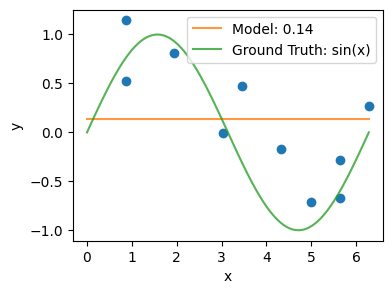

In [ ]:
print("\033[1mPrevious Model:\033[0m")
print(f"{s.model}\n")

s = theorist(s)

print("\n\033[1mUpdated Model:\033[0m")
print(s.model)

plot_from_state(s)

## Component Chaining

As such, we have our `AutoRA` components wrapped to work with the state. Remember, this means that they take the state as an input and returns the updated state as an output. As the components all act on the state, they can be chained.

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 15.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  1.516631
1  3.033262
2  4.333231
3  3.033262
4  1.949954
5  1.949954
6  5.633201
7  5.199877
8  0.866646
9  5.633201, experiment_data=           x       

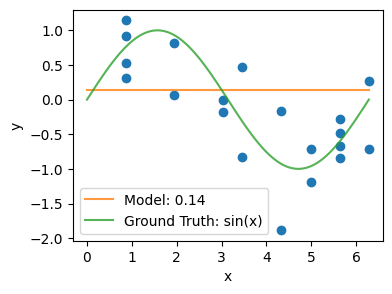

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:05<00:00, 17.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  3.033262
1  0.649985
2  3.899908
3  2.599939
4  2.816600
5  6.283185
6  1.083308
7  4.333231
8  0.649985
9  6.066524, experiment_data=           x       

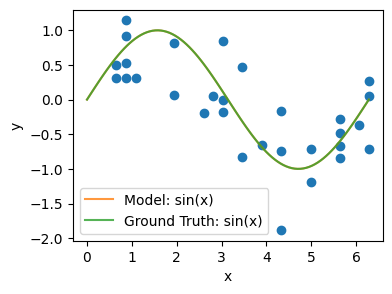

In [ ]:
#==========OPTION 1==========#
s = theorist(s)
s = experiment_runner(s)
s = experimentalist(s, num_samples=10)

print(s)
plot_from_state(s)

#==========OPTION 2==========#
s = theorist(experiment_runner(experimentalist(s, num_samples=10)))

print(s)
plot_from_state(s)

## The Cycle

Moreover, we can use these chained components within a loop to run multiple cycles.

### Cycle using Number of Cycles

INFO:autora.theorist.bms.regressor:BMS fitting started


100%|██████████| 100/100 [00:06<00:00, 15.95it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 1:
Cycle 1 model: -0.32


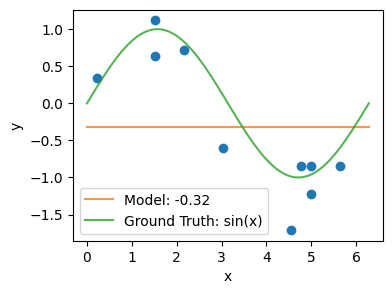

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 16.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 2:
Cycle 2 model: sin(x)


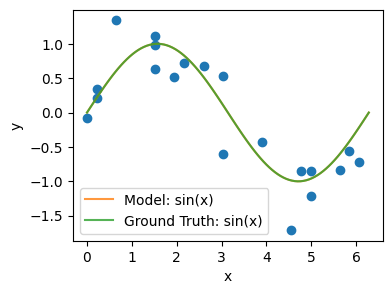

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 16.41it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 3:
Cycle 3 model: sin(x)


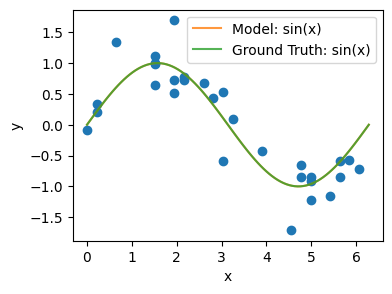

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 15.88it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 1:
Cycle 1 model: sin(x)


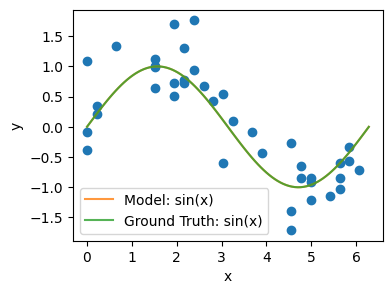

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 16.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 2:
Cycle 2 model: sin(x)


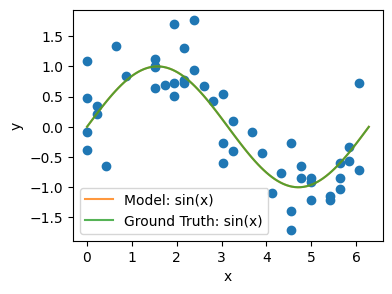

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:05<00:00, 17.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 3:
Cycle 3 model: 0.01


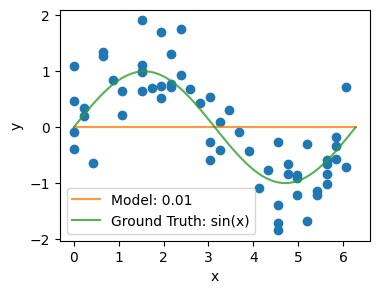

In [ ]:
#### First, let's reinitialize the state object to get a clean state ####
s = StandardState(
    variables = variables,
    conditions = conditions,
    experiment_data = pd.DataFrame(columns=["x","y"])
)

#==========OPTION 1==========#

### Then we cycle through the pipeline we built three times ###
num_cycles = 3 # number of empirical research cycles
for cycle in range(num_cycles):
    #Run pipeline
    s = theorist(experiment_runner(experimentalist(s, num_samples=10)))
    
    #Report metrics
    print(f"\n\033[1mRunning Cycle {cycle+1}:\033[0m")
    print(f"\033[1mCycle {cycle+1} model: {s.model}\033[0m")
    plot_from_state(s)
    
#==========OPTION 2==========#

### Then we cycle through the pipeline we built three more times ###
num_cycles = 3 # number of empirical research cycles
for cycle in range(num_cycles):
    #Run pipeline
    s = experimentalist(s, num_samples=10)
    s = experiment_runner(s)
    s = theorist(s)
    
    #Report metrics
    print(f"\n\033[1mRunning Cycle {cycle+1}:\033[0m")
    print(f"\033[1mCycle {cycle+1} model: {s.model}\033[0m")
    plot_from_state(s)

If everything went well in terms of our theorist, we should have recovered our ground truth model `sin(x)`:

In [ ]:
print(s.model)

sin(x)


### Cycle using Stopping Criteria

Alternatively, we can run the chain until we reach a stopping criterion. For example, here we will loop until we get 30 datapoints.

INFO:autora.theorist.bms.regressor:BMS fitting started
  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 17.11it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 1, number of datapoints: 10
Cycle 1 model: 0.47


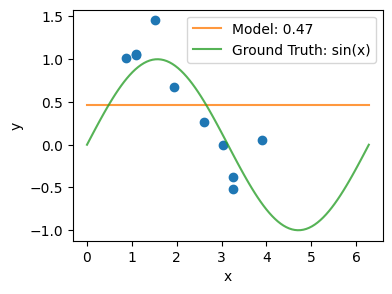

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 16.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 2, number of datapoints: 20
Cycle 2 model: sin(x)


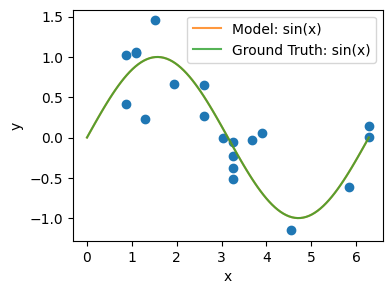

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 15.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 3, number of datapoints: 30
Cycle 3 model: sin(x)


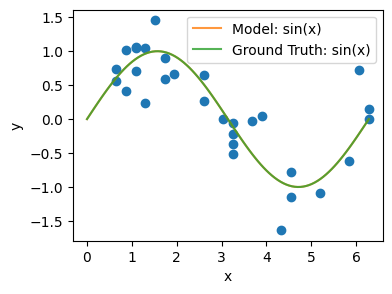

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:07<00:00, 13.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 4, number of datapoints: 40
Cycle 4 model: sin(x)


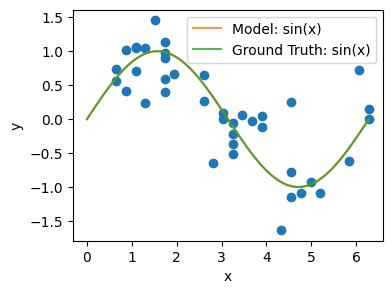

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:07<00:00, 13.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 5, number of datapoints: 50
Cycle 5 model: (0.53 ** x)


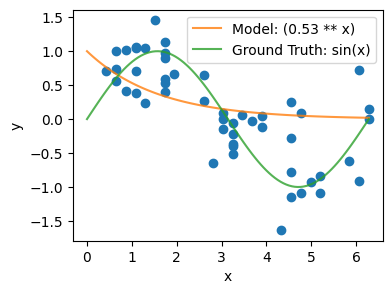


Number of datapoints: 50
Determined Model: (0.53 ** x)


In [ ]:
#### First, let's reinitialize the state object to get a clean state ####
s = StandardState(
    variables = variables,
    conditions = conditions,
    experiment_data = pd.DataFrame(columns=["x","y"])
)

### Then we cycle through the pipeline we built until we reach our stopping criterion ###
cycle = 0
while len(s.experiment_data) < 50: #Run until we have at least 50 datapoints
    #Run pipeline
    s = theorist(experiment_runner(experimentalist(s, num_samples=10)))
    
    #Report metrics
    print(f"\n\033[1mRunning Cycle {cycle+1}, number of datapoints: {len(s.experiment_data)}\033[0m")
    print(f"\033[1mCycle {cycle+1} model: {s.model}\033[0m")
    plot_from_state(s)
    
    #Increase count
    cycle += 1

print(f"\n\033[1mNumber of datapoints: {len(s.experiment_data)}\033[0m")
print(f"\033[1mDetermined Model: {s.model}\033[0m")

### The Conditional Cycle 

Because `AutoRA` components (theorist, experiment runner, experimentalist) act on the state, building a pipeline can have a lot of flexibility. Above, we demonstrated using a single set of components in different loops, but the components can also change respective to your criteria. In other words, you can use `if-else` statements to control which component is acting on the state.

For example, we can choose a different experimentalist depending on the number of datapoints we have collected.

In [ ]:
#### We will first define a new experimentalist
def uniform_sample(variables: VariableCollection, conditions: pd.DataFrame, num_samples = 1):

    """
    An experimentalist that selects the least represented datapoints
    """

    #Retrieve the possible values
    allowed_values = variables.independent_variables[0].allowed_values
    
    #Determine the representation of each value
    conditions_count = np.array([conditions["x"].isin([value]).sum(axis=0) for value in allowed_values])
    
    #Sort to determine the least represented values
    conditions_sort = conditions_count.argsort()
    
    conditions_count = conditions_count[conditions_sort]
    values_count = allowed_values[conditions_sort]
    
    #Sample from values with the smallest frequency
    x = values_count[conditions_count<=conditions_count[num_samples-1]]
    x = np.random.choice(x,num_samples)
    
    return pd.DataFrame({"x": x})

INFO:autora.theorist.bms.regressor:BMS fitting started


Using random pooler experimentalist...


100%|██████████| 100/100 [00:05<00:00, 17.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 1:
Cycle 1 model: -0.34


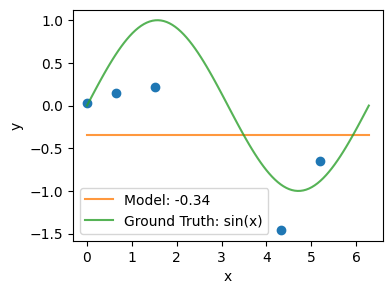

INFO:autora.theorist.bms.regressor:BMS fitting started


Using random pooler experimentalist...


100%|██████████| 100/100 [00:06<00:00, 16.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 2:
Cycle 2 model: -0.16


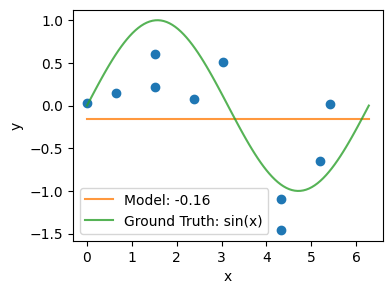

INFO:autora.theorist.bms.regressor:BMS fitting started


Using uniform sampler experimentalist...


100%|██████████| 100/100 [00:05<00:00, 17.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 3:
Cycle 3 model: sin(x)


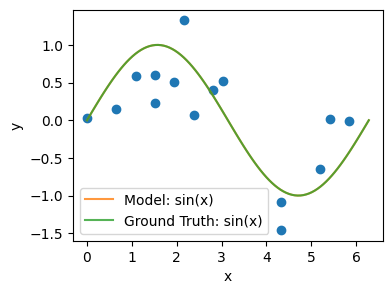

INFO:autora.theorist.bms.regressor:BMS fitting started


Using uniform sampler experimentalist...


100%|██████████| 100/100 [00:06<00:00, 16.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 4:
Cycle 4 model: sin(x)


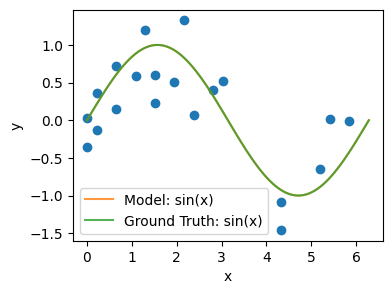

In [ ]:
from autora.experimentalist.random_ import random_pool

#### First, let's reinitialize the state object to get a clean state ####
s = StandardState(
    variables = variables,
    conditions = conditions,
    experiment_data = pd.DataFrame(columns=["x","y"])
)

#### Initiate both experimentalists ####
uniform_experimentalist = on_state(uniform_sample, output=["conditions"])
random_experimentalist = on_state(random_pool, output=['conditions'])

### Then we cycle through the pipeline we built until we reach our stopping criteria ###
cycle = 0
while len(s.experiment_data) < 20:
    
    #Run pipeline
    if len(s.experiment_data) < 10: #Conditional experimentalist: random for first half of cyles
        print('\033[1mUsing random pooler experimentalist...\033[0m')
        s = random_experimentalist(s, num_samples=5)
    else: #Conditional experimentalist: uniform for last half of cycles
        print('\033[1mUsing uniform sampler experimentalist...\033[0m')
        s = uniform_experimentalist(s, num_samples=5)
        
    s = experiment_runner(s)
    s = theorist(s)
    
    #Report metrics
    print(f"\n\033[1mRunning Cycle {cycle+1}:\033[0m")
    print(f"\033[1mCycle {cycle+1} model: {s.model}\033[0m")
    plot_from_state(s)
    
    #Increase count
    cycle += 1

In addition, we can dynamically change parameters across cycles.

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:05<00:00, 18.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 1:
Cycle 1 model: -0.38


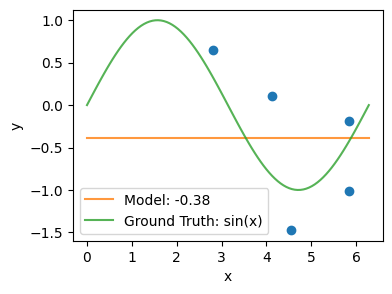

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 15.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 2:
Cycle 2 model: sin(x)


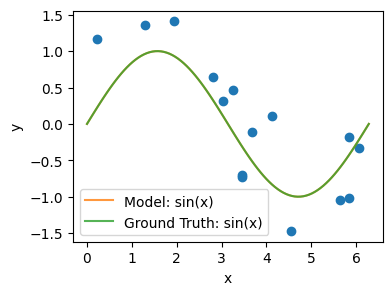

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 16.67it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 3:
Cycle 3 model: sin(x)


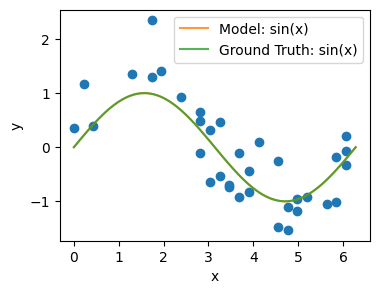

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:07<00:00, 14.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 4:
Cycle 4 model: (sin(x) / 0.97)


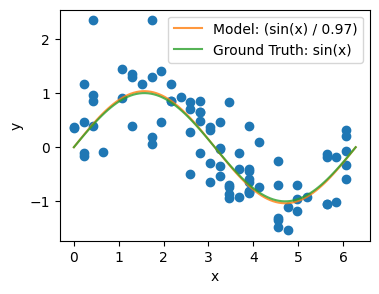

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:10<00:00,  9.10it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished



Running Cycle 5:
Cycle 5 model: cos((x * -0.52))


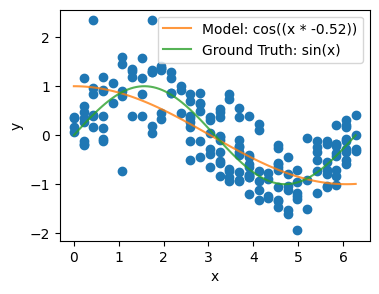

In [ ]:
from autora.experimentalist.random_ import random_pool

#### First, let's reinitialize the state object to get a clean state ####
s = StandardState(
    variables = variables,
    conditions = conditions,
    experiment_data = pd.DataFrame(columns=["x","y"])
)

#### Initiate both experimentalists ####
random_experimentalist = on_state(random_pool, output=['conditions'])

### Then we cycle through the pipeline we built until we reach our stopping criteria ###
for cycle, num_samples in enumerate([5, 10, 20, 50, 100]):
    
    #Run pipeline
    s = random_experimentalist(s, num_samples=num_samples)
    s = experiment_runner(s)
    s = theorist(s)
    
    #Report metrics
    print(f"\n\033[1mRunning Cycle {cycle+1}:\033[0m")
    print(f"\033[1mCycle {cycle+1} model: {s.model}\033[0m")
    plot_from_state(s)

In [ ]:
s.variables

VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[])

# Next Notebook
This concludes the tutorial on ``autora`` functionality. However, ``autora`` is a flexible framework in which users can integrate their own theorists, experimentalists, and experiment_runners in an automated empirical research workflow. The next notebook illustrates how to add your own custom theorists and experimentalists to use with ``autora``.

Follow this link for the next notebook tutorial:
[AutoRA Basic Tutorial IV: Customization](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-IV-Customization/) <br>